# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [ ]:
# libraries and packages import
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

In [ ]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Data download and preprocess

Be careful if you are running this on COLAB or locally.
Due to some bugs, datasets creation is different.
Change the lower COLAB bool to True if running on COLAB.

In [ ]:
COLAB = False  # if True, run on Google Colab, else on local repository

In [ ]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
N_EPOCHS = 30
VERBOSE = True

IF RUNNING ON COLAB

In [ ]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
# Only working on Colab (and locally if tfds.load works correctly)

def load_from_tfds():
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )


    # labels are folders names
    split_labels = ds_info.features['label'].names

    # returns label as one-hot
    to_ohe = lambda img, lbl: (img, tf.one_hot(lbl, depth=num_classes))

    ds_train = ds_train.map(to_ohe)
    ds_val = ds_val.map(to_ohe)
    ds_test = ds_test.map(to_ohe)

    num_classes  = len(split_labels)
    print(split_labels)

    return ds_train, ds_val, ds_test, split_labels, ds_info

In [ ]:
# if on colab, define preprocess.py
if COLAB:
    def preprocess(image, label, image_size=(128, 128)):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

IF RUNNING ON LOCAL REPOSITORY

If you are working on a local repository, first of all you need to clone the dataset into a local folder. 
Execute the command "git clone https://github.com/spMohanty/PlantVillage-Dataset" in the terminal while you are in a known path. Make sure to set the base_path variable below to point to that cloned folder. 

Only run the git clone command if you haven’t already downloaded the dataset to your PC.

In [ ]:
# Define local path to generate split
if not COLAB:
    from pathlib import Path
    from preprocessing import preprocess

    base_path = Path(r"D:\progetto-daml") #Change according to the path where PlantVillage-Dataset is cloned. A different path than progetto-daml is suggested.
    base_path = base_path / "PlantVillage-Dataset"
    #base_path = Path(r"/home/luchino/Desktop/ProgettoML/Dataset")

    OUTPUT_ROOT = base_path / "by_family"
    DS_DIR = OUTPUT_ROOT / "train"


In [ ]:
#ONLY RUN FIRST TIME, AFTER DATASET CLONING
'''

SOURCE_DIR = base_path / "raw/color"
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1

    # 2) Crea le directory di output (train, val, test)
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Preleva tutte le cartelle “disease” (una per classe)
    disease_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])

    # 4) Prepara le sottocartelle per ciascuna classe in ogni split
    for split in ("train","val","test"):
        for disease_dir in disease_dirs:
            class_name = disease_dir.name
            (OUTPUT_ROOT / split / class_name).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni classe, raccogli i file e spartiscili
    for disease_dir in disease_dirs:
        class_name = disease_dir.name
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<class_name>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/class_name/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/class_name/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/class_name/img.name)

        print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")
'''

In [ ]:
# splitting data into train, validation e test sets
def prepare_local_dataset():
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()])

    ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='categorical',
    )

    ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True,
    )

    ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True,
    )

    return ds_train_ohe, ds_val_ohe, ds_test_ohe, split_labels

# Training


In [ ]:
# cnn layers
def simple_cnn(input_shape, num_classes, l2_coef=1e-3):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_coef)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(l2_coef)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        #Conv2D(128, (3, 3), padding='same'),
        #BatchNormalization(),
        #Activation('relu'),
        #MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        #Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_coef))
    ])
    return model

In [ ]:
# preprocess and batch datasets. Useful objects are defined
def model_preprocess(COLAB):
    if COLAB:
        ds_train, ds_val, ds_test, split_labels, ds_info = load_from_tfds()
        ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
        ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        '''if VERBOSE:
          tfds.show_examples(ds_train, ds_info)'''
    else:
        ds_train, ds_val, ds_test, split_labels = prepare_local_dataset()

    num_classes = len(split_labels)
    tag = "38_families"
    checkpoint = f"best_model_{tag}_focal.h5"

    return ds_train, ds_val, ds_test, split_labels, num_classes, checkpoint


In [ ]:
# model compilation

def model_train(num_classes):
    model = simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)

    optimizer = Adam(learning_rate=0.001)
    #optimizer = SGD(learning_rate=0.05, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(alpha = 0.25, gamma = 2),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
    model.summary()
    return model


In [ ]:
# program running (all the functions above are executed)
train_set, val_set, test_set, split_labels, num_classes, checkpoint_file = model_preprocess(COLAB)

Found 43429 files belonging to 38 classes.
Found 5417 files belonging to 38 classes.
Found 5459 files belonging to 38 classes.


In [ ]:
# debug prints
print(split_labels)
print(len(split_labels))
print(checkpoint_file)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust_', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mo

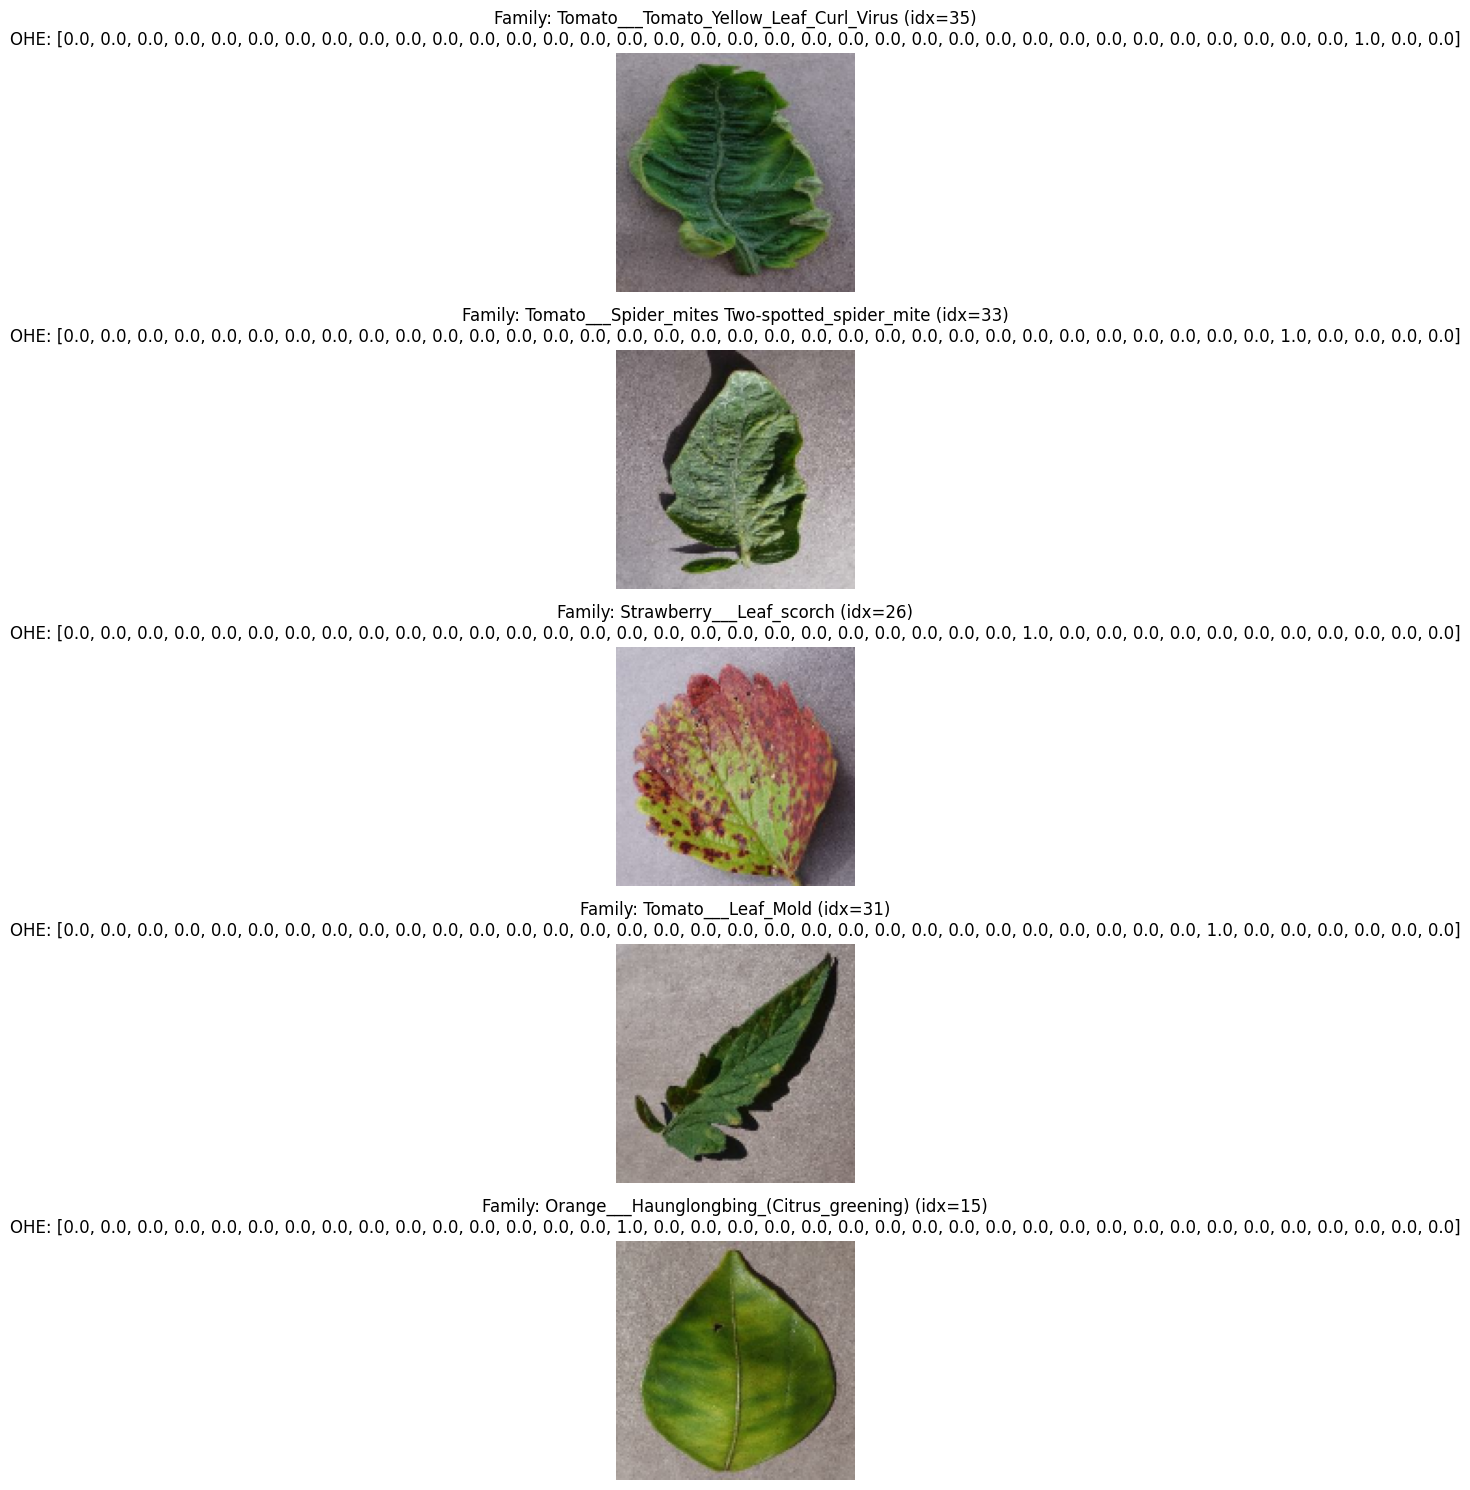

In [ ]:
# debug print for families - ohe labels cross check
def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Tensors are converted into numpy arrays
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # one-hot vector
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # family index
        fam_name = split_labels[fam_idx]

        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# example on train batch
display_samples_with_labels_ohe(train_set, num_samples=5)


In [163]:
# counting how many images per class
from collections import Counter

counts = Counter()

for _, batch_labels in train_set:
    idxs = np.argmax(batch_labels.numpy(), axis=1)
    counts.update(idxs)

print(f"Number of classes: {len(split_labels)}")
print("Number of images per class:")
for idx in range(len(split_labels)):
    print(f"{split_labels[idx]}: {counts[idx]} images")

Number of classes: 38
Number of images per class:
Apple___Apple_scab: 504 images
Apple___Black_rot: 496 images
Apple___Cedar_apple_rust: 220 images
Apple___healthy: 1316 images
Blueberry___healthy: 1201 images
Cherry___Powdery_mildew: 841 images
Cherry___healthy: 683 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 410 images
Corn___Common_rust_: 953 images
Corn___Northern_Leaf_Blight: 788 images
Corn___healthy: 929 images
Grape___Black_rot: 944 images
Grape___Esca_(Black_Measles): 1106 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 860 images
Grape___healthy: 338 images
Orange___Haunglongbing_(Citrus_greening): 4405 images
Peach___Bacterial_spot: 1837 images
Peach___healthy: 288 images
Pepper,_bell___Bacterial_spot: 797 images
Pepper,_bell___healthy: 1182 images
Potato___Early_blight: 800 images
Potato___Late_blight: 800 images
Potato___healthy: 121 images
Raspberry___healthy: 296 images
Soybean___healthy: 4072 images
Squash___Powdery_mildew: 1468 images
Strawberry___Leaf_scorch

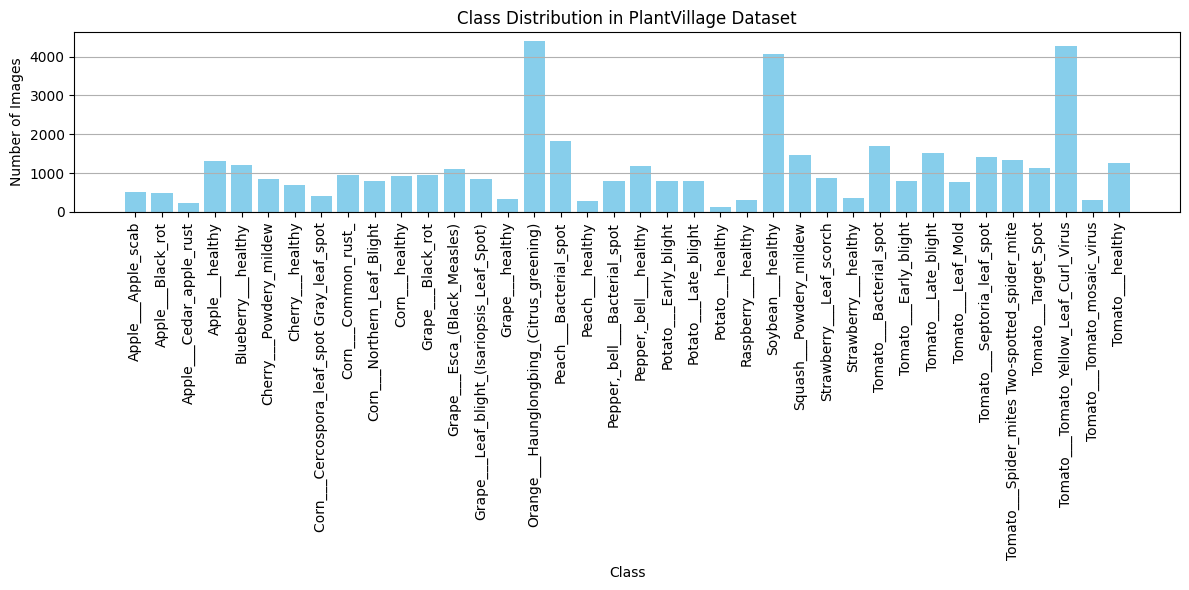

In [164]:
# Visualize the class distribution
counts_list = [counts[i] for i in range(len(split_labels))]

plt.figure(figsize=(12, 6))
plt.bar(split_labels, counts_list, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in PlantVillage Dataset')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [165]:
# Print element format
print("Element spec:", train_set.element_spec)

# Example on a batch
for batch in train_set.take(1):
    x, y = batch
    print("x shape:", x.shape, "  dtype:", x.dtype)
    print("y shape:", y.shape, "  dtype:", y.dtype)


Element spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))
x shape: (32, 128, 128, 3)   dtype: <dtype: 'float32'>
y shape: (32, 38)   dtype: <dtype: 'float32'>


In [166]:
model = model_train(num_classes)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 38)             │     4,980,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,986,054 (19.02 MB)

 Trainable params: 4,985,958 (19.02 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
# Model training - Saving best model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)

Epoch 1/35
 419/1358 ━━━━━━━━━━━━━━━━━━━━ 16:27 1s/step - accuracy: 0.2300 - loss: 3.1876

In [ ]:
#DECOMMENT IF DATASET IS NOT SPLIT YET
'''
if FAM_SPLIT:
    # 1) Configurazione
    #SOURCE_DIR   = Path(r"D:\progetto-daml\PlantVillage-Dataset\raw\color")
    #OUTPUT_ROOT  = Path(r"D:\progetto-daml\PlantVillage-Dataset\by_family")
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_family")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Raccogli classi di disease e mappa a famiglia
    disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
    families = sorted({d.name.split("___")[0] for d in disease_folders})

    # 4) Prepara le cartelle per ogni famiglia e split
    for split in ("train","val","test"):
        for fam in families:
            (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni disease, raccogli i file e spartiscili
    for disease_dir in disease_folders:
        fam = disease_dir.name.split("___")[0]
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<fam>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

    print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")

else:
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_disease")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output (train, val, test)
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Preleva tutte le cartelle “disease” (una per classe)
    disease_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])

    # 4) Prepara le sottocartelle per ciascuna classe in ogni split
    for split in ("train","val","test"):
        for disease_dir in disease_dirs:
            class_name = disease_dir.name
            (OUTPUT_ROOT / split / class_name).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni classe, raccogli i file e spartiscili
    for disease_dir in disease_dirs:
        class_name = disease_dir.name
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<class_name>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/class_name/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/class_name/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/class_name/img.name)

        print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")
'''

'\nif FAM_SPLIT:\n    # 1) Configurazione\n    #SOURCE_DIR   = Path(r"D:\\progetto-daml\\PlantVillage-Dataset\raw\\color")\n    #OUTPUT_ROOT  = Path(r"D:\\progetto-daml\\PlantVillage-Dataset\x08y_family")\n    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_family")\n    TRAIN_FRAC   = 0.8\n    VAL_FRAC     = 0.1\n    TEST_FRAC    = 0.1\n    SEED         = 42\n\n    random.seed(SEED)\n\n    # 2) Crea le directory di output\n    for split in ("train","val","test"):\n        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)\n\n    # 3) Raccogli classi di disease e mappa a famiglia\n    disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])\n    families = sorted({d.name.split("___")[0] for d in disease_folders})\n\n    # 4) Prepara le cartelle per ogni famiglia e split\n    for split in ("train","val","test"):\n        for fam in families:\n            (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)\n\n    # 5) Per ogni disease, r

# History


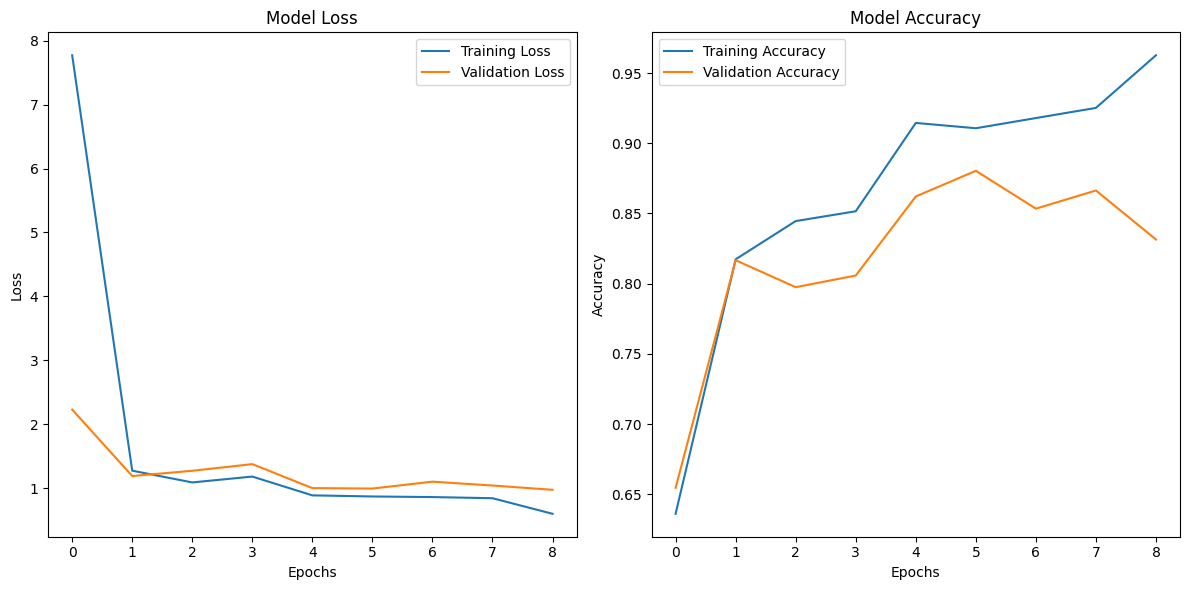

In [ ]:
# plot training history (Loss and Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [ ]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential

#with keras.utils.custom_object_scope({'Sequential': Sequential}):
#model = keras.models.load_model('best_model_wo_augmentation.h5')
y_true = []
y_pred = []
y_score = []
for images, labels in test_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.873054
Precision: 0.881522
Recall: 0.873054
F1-score: 0.869299


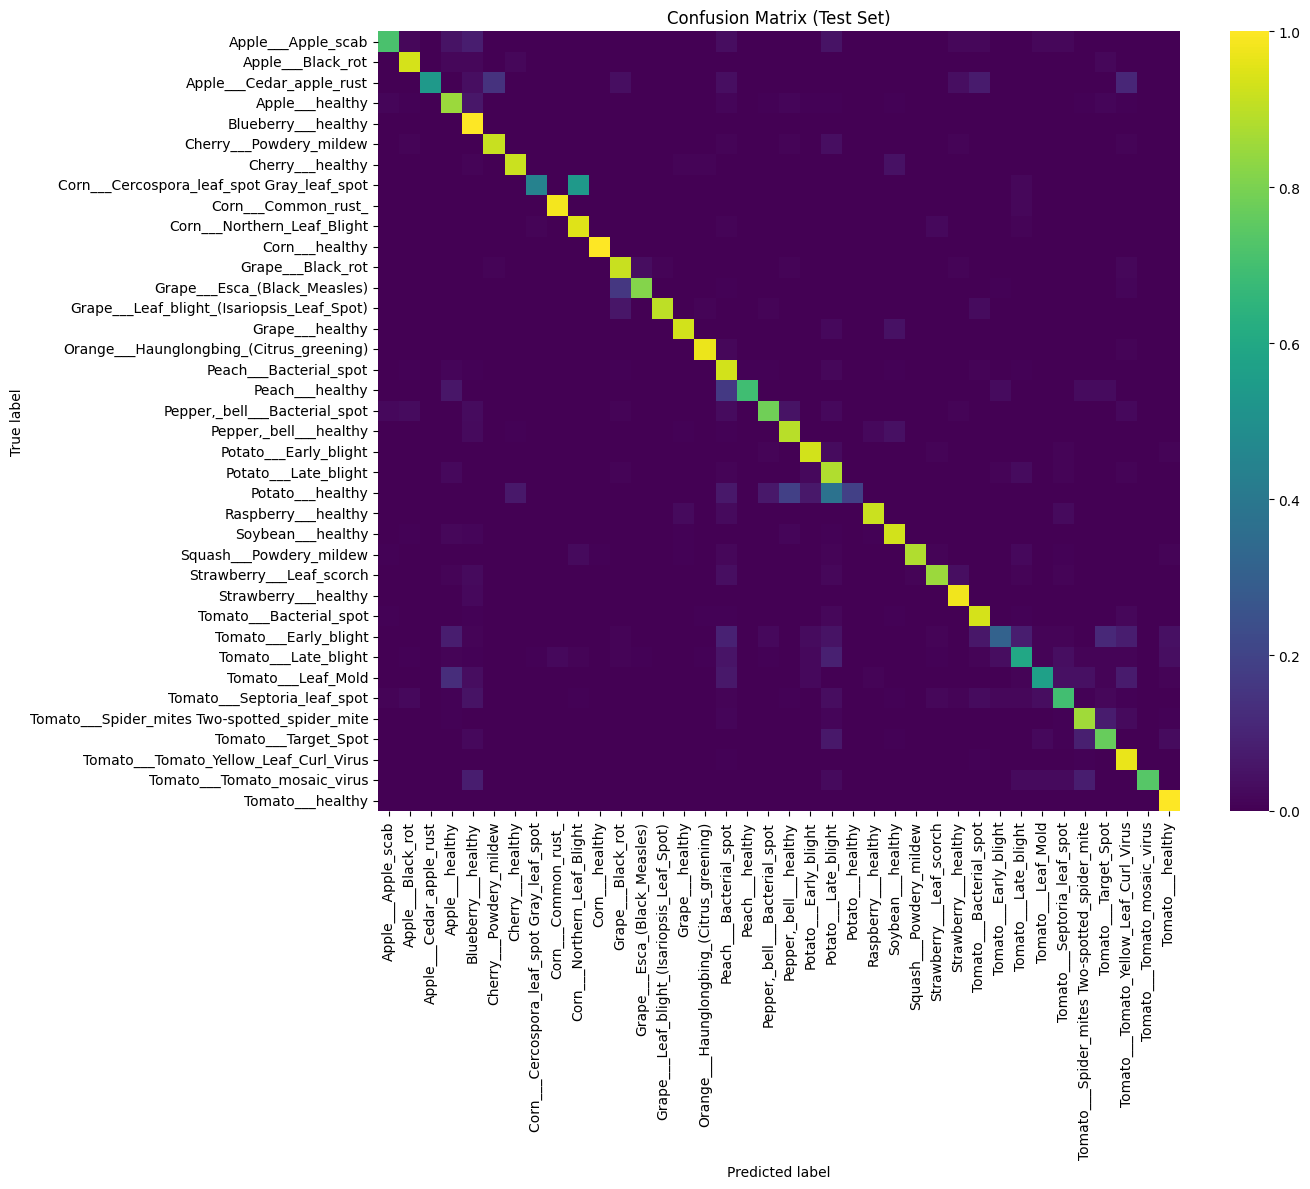

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print(y_score.shape[1])


38


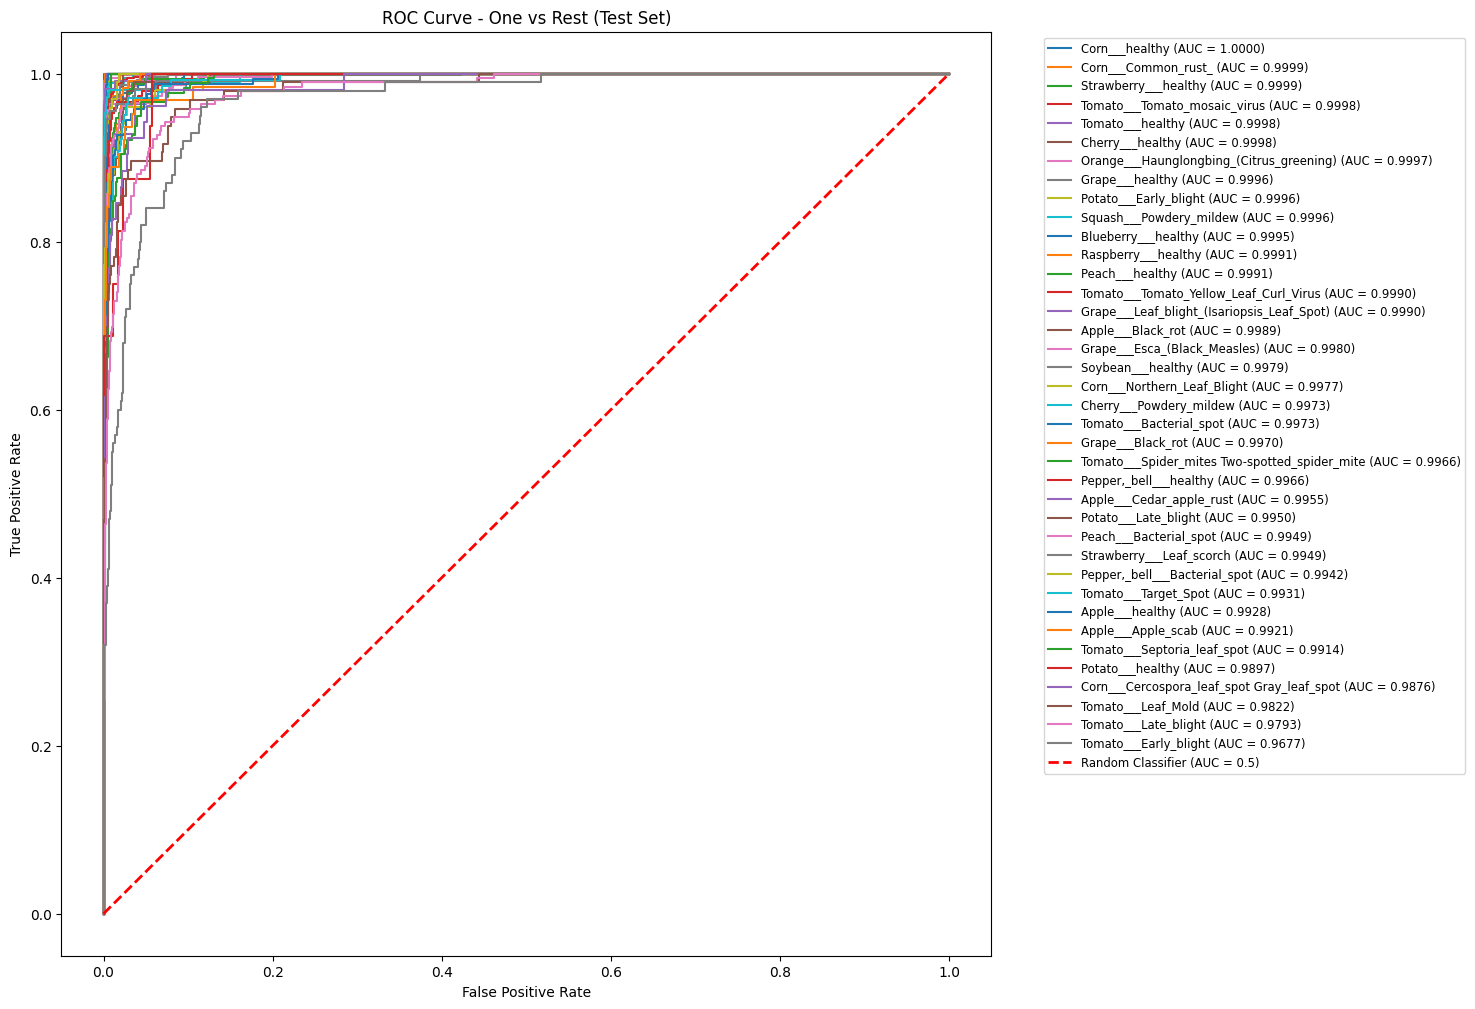

In [ ]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
'''
plt.yscale('log')
plt.xscale('log')
'''
plt.show()


In [ ]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.85      0.71      0.78        63
                            Apple___Black_rot       0.81      0.94      0.87        63
                     Apple___Cedar_apple_rust       1.00      0.54      0.70        28
                              Apple___healthy       0.76      0.85      0.80       165
                          Blueberry___healthy       0.72      1.00      0.84       151
                      Cherry___Powdery_mildew       0.95      0.92      0.93       106
                             Cherry___healthy       0.95      0.92      0.93        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.44      0.60        52
                          Corn___Common_rust_       0.97      0.98      0.98       120
                  Corn___Northern_Leaf_Blight       0.72      0.95      0.82        99
                               Corn___heal